```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

## Demographic Bias Analysis FairFace

Results are recorded in .txt files.

In [1]:
import math
import os
import random
import shlex
import subprocess
import sys
import time
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import Rectangle
from PIL import Image

## Add seed for reproducibility
random.seed(42)
np.random.seed(42)

In [2]:
# ! rm -rf attached

In [3]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

# Collecting and Cleaning Data

In [4]:
def get_filepaths(directory):
    file_paths = []  # List which will store all of the full filepaths.
    file_paths = [str(p) for p in Path(directory).glob("*")]
    return file_paths

## Read and process data

In [5]:
# [Instruction]: out the folder directory which contains all the images here
IMG_DIR_PATH = data_dir / "./fairface/fairface-img-margin125-trainval/"
print("Directory exists:", Path(IMG_DIR_PATH).exists())

# get the list of all files path
full_file_paths = get_filepaths(IMG_DIR_PATH / "./train")

Directory exists: True


In [83]:
from PIL import Image
import cv2
from tqdm import tqdm

def is_RGB(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return True
    return False

cascPath = "haarcascade_frontalface_default.xml"

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

def no_of_faces(img_path):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
    return len(faces)
    

In [88]:
# tqdm.pandas()

# DATA_PATH = data_dir / "./fairface/fairface_label_train.csv"
# print("File exists:", Path(DATA_PATH).exists())

# df = pd.read_csv(DATA_PATH)
# df["path"] = df.file.apply(lambda x: IMG_DIR_PATH / x)
# df = df[df["race"].isin(["White", "Black", "Indian", "East Asian"])]
# df = df[df["age"].isin(["20-29", "30-39", "40-49"])]

# df['RGB'] = df['path'].progress_apply(is_RGB)
# df = df[df['RGB'] == True]

# df['faces'] = df['path'].progress_apply(no_of_faces)
# df = df[df['faces'] <= 1]

# DATA_PATH = data_dir / "./fairface/fairface_label_train_cleaned.csv"
# df.to_csv(DATA_PATH, index=False)

# df

In [89]:
DATA_PATH = data_dir / "./fairface/fairface_label_train_cleaned.csv"
print("File exists:", Path(DATA_PATH).exists())

df = pd.read_csv(DATA_PATH)
df = df[df["race"].isin(["White", "Black", "Indian", "East Asian"])]
df = df[df["age"].isin(["20-29", "30-39", "40-49"])]                

df

File exists: True


,file,age,gender,race,service_test,path,RGB,faces
0,train/2.jpg,30-39,Female,Indian,False,../data/fairface/fairface-img-margin125-trainv...,True,1
1,train/4.jpg,20-29,Female,Indian,True,../data/fairface/fairface-img-margin125-trainv...,True,0
2,train/6.jpg,20-29,Male,White,True,../data/fairface/fairface-img-margin125-trainv...,True,1
3,train/8.jpg,30-39,Female,Indian,True,../data/fairface/fairface-img-margin125-trainv...,True,0
4,train/12.jpg,20-29,Male,East Asian,False,../data/fairface/fairface-img-margin125-trainv...,True,1
...,...,...,...,...,...,...,...,...
27822,train/86729.jpg,20-29,Female,East Asian,False,../data/fairface/fairface-img-margin125-trainv...,True,1
27823,train/86733.jpg,40-49,Female,White,False,../data/fairface/fairface-img-margin125-trainv...,True,1
27824,train/86737.jpg,20-29,Male,Black,False,../data/fairface/fairface-img-margin125-trainv...,True,1
27825,train/86740.jpg,20-29,Male,Indian,True,../data/fairface/fairface-img-margin125-trainv...,True,1


In [90]:
RACE_SIZE_THRESHOLD = 40
race_size_pandas = df.groupby("race").size()
print(
    "top race group by size:\n", race_size_pandas.sort_values(ascending=False)[:20]
)
race_big_enough = race_size_pandas[
    race_size_pandas.values >= RACE_SIZE_THRESHOLD
].index.values

top race group by size:
 race
White         9269
East Asian    6495
Black         6046
Indian        6017
dtype: int64


In [91]:
# cut if the group is too small
GROUP_THRESHOLD = 100

def get_grouped_images(
    df, by_columns=["race"], group_threshold=GROUP_THRESHOLD
):
    """
    race_threshold: if the size of the group is less than the threshold, then ignore the group to be in the dictionary
    """
    grouped_images_dict = {}
    grouped_images_race = df.groupby(by_columns)

    for name, group in grouped_images_race:
        print(name)
        print("Size of the group:", len(group))
        if group_threshold is not None:
            if len(group) < group_threshold:
                print("\tSize is smaller than", group_threshold, ". Skip this group.")
                continue
        grouped_images_dict[name] = group

    return grouped_images_dict

In [92]:
# choose your option here
grouped_images_dict = get_grouped_images(
    df, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('East Asian', 'Female')
Size of the group: 3482
('East Asian', 'Male')
Size of the group: 3013
('Indian', 'Female')
Size of the group: 2792
('Indian', 'Male')
Size of the group: 3225
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [93]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('East Asian', 'Female'), ('East Asian', 'Male'), ('Indian', 'Female'), ('Indian', 'Male'), ('White', 'Female'), ('White', 'Male')])

# Setting up Tools to use

In [94]:
def img_resize_fixed_aspect(img, fixed_width=None, fixed_height=256):
    w, h = img.size
    if fixed_height:
        return img.resize((int(w * fixed_height / h), fixed_height))
    elif fixed_width:
        raise Exception("Not implemented.")


def attach_img(
    images,
    fixed_height=None,
    display_img_full_size=False,
    display_figsize=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of images (of PIL Image class or image paths), attach them horizontally and return a new image.
    
    images: list of images or a list of paths to images
    fixed_height: all images are resized (while fixing the aspect ratio) to the specified height.
    If you don't want to resize, set this to None
    display_img_full_size: If true, will display the image at full resolution
    display_figsize: if given, as (x,y), will use matplotlib to display images with figsize=(x,y)
    pixel_size_upperbound: if given, images with width or height above this number will be resized down 
    while fixing the aspect ratio until both the width and height is at most the number.
    """
    if isinstance(images[0], str) or isinstance(images[0], Path):
        images = [Image.open(str(img_path)) for img_path in images]
    if fixed_height is not None:
        images = [
            img_resize_fixed_aspect(img, fixed_height=fixed_height) for img in images
        ]
    if pixel_size_upperbound is not None:
        for i in range(len(images)):
            w, h = images[i].size
            if w > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (pixel_size_upperbound, int(pixel_size_upperbound / w * h))
                )
            w, h = images[i].size
            if h > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (int(pixel_size_upperbound / h * w), pixel_size_upperbound)
                )
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new("RGB", (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if display_img_full_size:
        display(new_im)  # This shows image at full resolution
    if display_figsize:
        fig = plt.figure(figsize=display_figsize)
        plt.imshow(
            np.asarray(new_im)
        )  # This shows scaled down version in matplotlib plot using figsize
    return (new_im, widths, heights)

### Run below cell if want to explore the images

Black  size:  7091


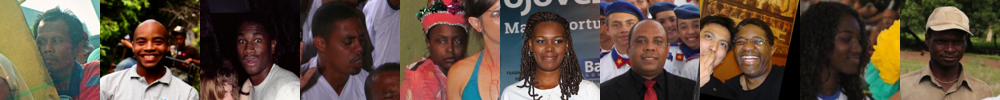

East Asian  size:  7864


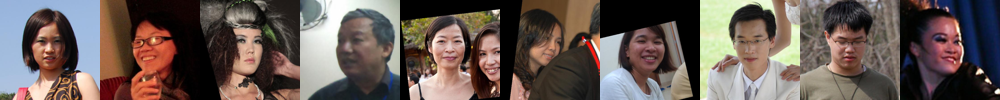

Indian  size:  7377


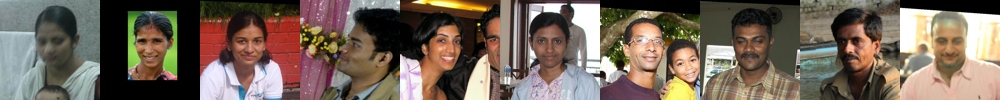

White  size:  11279


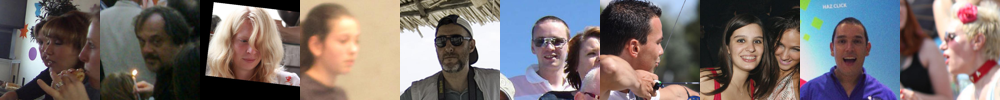

Female


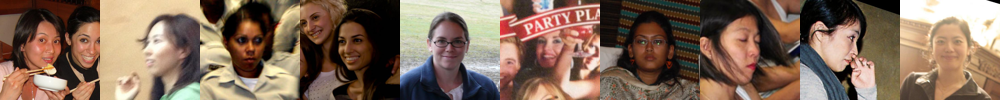

Male


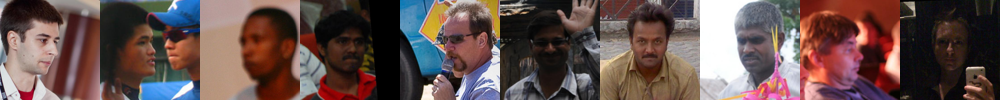

In [14]:
for race in race_big_enough:
    print(
        race, " size: ", race_size_pandas.loc[race]
    )
    display(
        attach_img(
            df[df.race == race]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

for gender in df.gender.unique():
    print(gender)
    display(
        attach_img(
            df[df.gender == gender]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

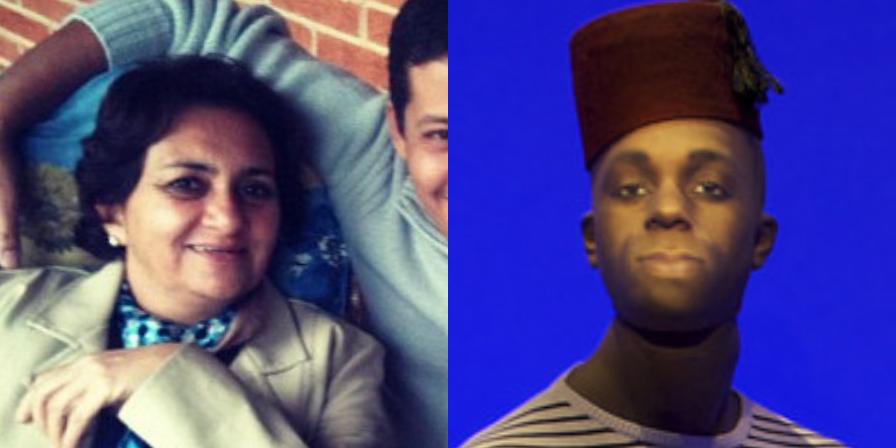

widths: (448, 448)
heights: (448, 448)


In [15]:
(new_im, widths, heights) = attach_img(full_file_paths[0:2], fixed_height=None)
display(new_im)
print("widths:", widths)
print("heights:", heights)


In [16]:
def locate_which_img(location, widths):
    """
    Given a list of widths of the images that are attached (from left to right), and a location,
    output what image contains that location.
    E.g. widths = 100, 200, 100
    location = 50 --> index = 0
    location = 350 --> index = 2
    location = 100 --> index = 1
    location >= 400 --> index = -1
    """
    index = 0
    while location >= widths[index]:
        location -= widths[index]
        index += 1
        if index >= len(widths):
            return -1
    return index

In [17]:
def parse_output(output):
    output = output.splitlines()
    final_output = {"salient_point": [], "crops": [], "all_salient_points": []}
    key = "salient_point"
    for i, line in enumerate(output):
        line = line.split()
        if len(line) in {2, 4}:
            line = [int(v) for v in line]
            if i != 0:
                key = "crops"
        elif len(line) == 3:
            key = "all_salient_points"
            line = [float(v) for v in line]
        else:
            raise RuntimeError(f"Invalid line: {line}")
        final_output[key].append(line)
    return final_output

In [18]:
def get_salient_info(img_path):
    """
    Given a path (as an instance of Path or a string or an image), output the salient information.
    
    The output is a dictionary with:
    'salient_point': a list of pixels, usually only one. E.g. [[507, 328]]
    'crops': a list of crops (for each aspect ratio) in the format crop_x crop_y crop_w crop_h
    'all_salient_points': the pixel location at the original image with its salient score. It is a list of
    [x, y, salient score]
    """
    if isinstance(img_path, str):
        img_path = Path(img_path)
    try:
        cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
        output = subprocess.check_output(cmd, shell=True)  # Success!
        return parse_output(output)
    except:
        print("Running the model to get salient point fails. Returning None.")
        return None

In [19]:
salient_scores = [
    point[2] for point in get_salient_info(full_file_paths[3])["all_salient_points"]
]
np.percentile(salient_scores, 100)
np.mean(salient_scores)

0.5868125209449999

## Higher-level Tools

In [20]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [21]:
RESULT_FILE_PATH = data_dir / "./fairface_4race_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

### Pairwise comparison

In [22]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [23]:
def compute_group_comparison(
    df_list,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    log_every=100,
    warn_outside_ori_image=True,
    fixed_height=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of dataframe of groups g_1, g_2, ..., g_k, each of which contains the column 'path' to the image file:
    - sample uniformly one image from each group
    - attach image into one image
    - apply saliency mapping
    - find the number of times max salient points land in each picture
    """
    num_max_salient_per_group = np.zeros(len(df_list))
    for i in range(num_iterations):
        salient_info = None
        while salient_info is None:  # if cmd in get_salient_info failed, resample
            # Sample images as paths
            sample_img_paths = [(df.sample())["path"].item() for df in df_list]
            attached_img, widths, heights = attach_img(
                sample_img_paths,
                fixed_height=fixed_height,
                pixel_size_upperbound=pixel_size_upperbound,
            )
            attached_path = str(save_dir) + "/" + str(i) + ".jpg"
            attached_img.save(attached_path)
            # try to get salient information. Will get None if fails.
            salient_info = get_salient_info(attached_path)

        # get salient point and where it lands
        all_salient_points = salient_info["salient_point"]
        if len(all_salient_points) > 1:
            print(
                "Warning: there is more than one maximum salient point. Using the first one returned from the algorithms."
            )
        salient_point_x, salient_point_y = all_salient_points[0]
        max_salient_pic_index = locate_which_img(salient_point_x, widths)
        if warn_outside_ori_image and salient_point_y >= heights[max_salient_pic_index]:
            # this means the point is outside of the original image
            print(
                "Warning: salient point is located at the background from attaching images, outside of original."
            )
        num_max_salient_per_group[max_salient_pic_index] += 1
        if (i + 1) % log_every == 0:
            print((i + 1), "/", num_iterations, "iterations of sampling has been done.")
    return num_max_salient_per_group

In [24]:
# In general, we can give the name of two groups in grouped_images_dict, and return this statistics of how many land in each
def compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    normalize=False,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    fixed_height=None,
    pixel_size_upperbound=None,
    save_result=RESULT_FILE_PATH,
    log_every=100,
    print_summary=True,
    save_setting="default",
):
    """
    Given a list of group names, which are keys of the dictionary grouped_images_dict,
    whose values are pandas dataframe with column "path",
    return the number of times salient points lands in each of the group out of num_iterations iterations of sampling.
    
    Args:
        grouped_images_dict: a dictionary where keys are group names, and values are pandas dataframe which contains 'path'
    """
    start_time = time.time()
    stats = compute_group_comparison(
        [grouped_images_dict[group_name] for group_name in group_name_list],
        save_dir=save_dir,
        num_iterations=num_iterations,
        fixed_height=fixed_height,
        log_every=log_every,
        pixel_size_upperbound=pixel_size_upperbound,
    )
    if normalize:
        stats = stats / num_iterations
    if print_summary:
        print("The groups entered are: " + str(group_name_list))
        print("The statistic is: " + str(stats))
        print("Size of the sample: " + str(num_iterations))
    if save_result:
        with open(RESULT_FILE_PATH, "a") as fp:
            to_write_info_dict = {
                "group_name_list": group_name_list,
                "stats": stats,
                "num_iterations": num_iterations,
            }
            if save_setting:
                to_write_info_dict["setting"] = save_setting
            fp.write(str(to_write_info_dict) + "\n")
    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / num_iterations, "seconds.")
    return stats

### Get a list of saliency point statistics

Such as max, 95th, 90th, 50th, and 25th percentile

In [25]:
def compute_saliency_stats(
    file_path_list,
    sample=None,
    percentile_queries=[25, 50, 75, 90, 95, 100],
    fixed_height=None,
    pixel_size_upperbound=None,
    save_dir=SAVE_DIR_ATTACHED,
    log_every=100,
    print_summary=True,
    delete_img=True,
):
    """
    Given a list of paths to images, compute saliency statistics of interests of all those images.
    
    Args:
        sample: None if we want to compute all. If a number is given, only do the specified number of samples (without replacement)

    Returns:
        pandas dataframe with file_path as an index, and the statistics as a column
    """
    start_time = time.time()

    if sample is not None:
        file_path_list = random.sample(file_path_list, sample)

    result_data = {
        str(percent) + "%_tile": [] for percent in percentile_queries
    }  # all columns
    result_data["path"] = []  # rows of the data
    result_data["mean"] = []

    for i, path in enumerate(file_path_list):
        attached_img, widths, heights = attach_img(
            [path],
            fixed_height=fixed_height,
            pixel_size_upperbound=pixel_size_upperbound,
        )
        attached_path = str(save_dir) + "/" + str(i) + ".jpg"
        attached_img.save(attached_path)
        # try to get salient information. Will get None if fails.
        salient_info = get_salient_info(attached_path)
        # After getting the info delete the file:
        if delete_img:
            Path(attached_path).unlink()

        salient_scores = [point[2] for point in salient_info["all_salient_points"]]

        # put data in
        result_data["path"].append(path)
        result_data["mean"].append(np.mean(salient_scores))
        for percent in percentile_queries:
            result_data[str(percent) + "%_tile"].append(
                np.percentile(salient_scores, percent)
            )

        if (i + 1) % log_every == 0:
            print((i + 1), "iterations of sampling has been done.")

    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / len(file_path_list), "seconds.")

    return pd.DataFrame.from_dict(result_data).set_index("path")

# Analysis

Change the setting and setting name below (for saving purpose), and modify `all_pairs_replicate_ori` as needed.

In [26]:
# change the setting here
NUM_ITERATION = 200
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_4race_fixed_height_intersect"  # for saving results and plots

In [27]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [28]:
# another way, if we want to flip
all_pairs_replicate_ori

[(('Black', 'Female'), ('Black', 'Male')),
 (('Black', 'Female'), ('East Asian', 'Female')),
 (('Black', 'Female'), ('East Asian', 'Male')),
 (('Black', 'Female'), ('Indian', 'Female')),
 (('Black', 'Female'), ('Indian', 'Male')),
 (('Black', 'Female'), ('White', 'Female')),
 (('Black', 'Female'), ('White', 'Male')),
 (('Black', 'Male'), ('East Asian', 'Female')),
 (('Black', 'Male'), ('East Asian', 'Male')),
 (('Black', 'Male'), ('Indian', 'Female')),
 (('Black', 'Male'), ('Indian', 'Male')),
 (('Black', 'Male'), ('White', 'Female')),
 (('Black', 'Male'), ('White', 'Male')),
 (('East Asian', 'Female'), ('East Asian', 'Male')),
 (('East Asian', 'Female'), ('Indian', 'Female')),
 (('East Asian', 'Female'), ('Indian', 'Male')),
 (('East Asian', 'Female'), ('White', 'Female')),
 (('East Asian', 'Female'), ('White', 'Male')),
 (('East Asian', 'Male'), ('Indian', 'Female')),
 (('East Asian', 'Male'), ('Indian', 'Male')),
 (('East Asian', 'Male'), ('White', 'Female')),
 (('East Asian', 'Male

In [29]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 200 iterations of sampling has been done.
200 / 200 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [119.  81.]
Size of the sample: 200
total time used: 52.608524799346924 seconds.
time used per comparison: 0.2630426239967346 seconds.
100 / 200 iterations of sampling has been done.
200 / 200 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('East Asian', 'Female'))
The statistic is: [ 83. 117.]
Size of the sample: 200
total time used: 52.17783451080322 seconds.
time used per comparison: 0.2608891725540161 seconds.
100 / 200 iterations of sampling has been done.
200 / 200 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('East Asian', 'Male'))
The statistic is: [108.  92.]
Size of the sample: 200
total time used: 53.50497078895569 seconds.
time used per comparison: 0.26752485394477843 seconds.
100 / 200 iterations of sampling has been done.

100 / 200 iterations of sampling has been done.
200 / 200 iterations of sampling has been done.
The groups entered are: (('Indian', 'Male'), ('White', 'Male'))
The statistic is: [ 98. 102.]
Size of the sample: 200
total time used: 58.70109462738037 seconds.
time used per comparison: 0.29350547313690184 seconds.
100 / 200 iterations of sampling has been done.
200 / 200 iterations of sampling has been done.
The groups entered are: (('White', 'Female'), ('White', 'Male'))
The statistic is: [111.  89.]
Size of the sample: 200
total time used: 55.06841158866882 seconds.
time used per comparison: 0.2753420579433441 seconds.


In [30]:
def plot_pairwise_stats(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [
        "{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
        for pair in stat_dict.keys()
    ]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    if middle_band_width is not None:
        ax.axhline(0.5, color="r", label=f"Demographic Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [31]:
max_salient_compare_dict

{(('Black', 'Female'), ('Black', 'Male')): array([119.,  81.]),
 (('Black', 'Female'), ('East Asian', 'Female')): array([ 83., 117.]),
 (('Black', 'Female'), ('East Asian', 'Male')): array([108.,  92.]),
 (('Black', 'Female'), ('Indian', 'Female')): array([103.,  97.]),
 (('Black', 'Female'), ('Indian', 'Male')): array([110.,  90.]),
 (('Black', 'Female'), ('White', 'Female')): array([102.,  98.]),
 (('Black', 'Female'), ('White', 'Male')): array([115.,  85.]),
 (('Black', 'Male'), ('East Asian', 'Female')): array([ 83., 117.]),
 (('Black', 'Male'), ('East Asian', 'Male')): array([110.,  90.]),
 (('Black', 'Male'), ('Indian', 'Female')): array([ 73., 127.]),
 (('Black', 'Male'), ('Indian', 'Male')): array([ 95., 105.]),
 (('Black', 'Male'), ('White', 'Female')): array([ 77., 123.]),
 (('Black', 'Male'), ('White', 'Male')): array([ 84., 116.]),
 (('East Asian', 'Female'), ('East Asian', 'Male')): array([110.,  90.]),
 (('East Asian', 'Female'), ('Indian', 'Female')): array([114.,  86.])

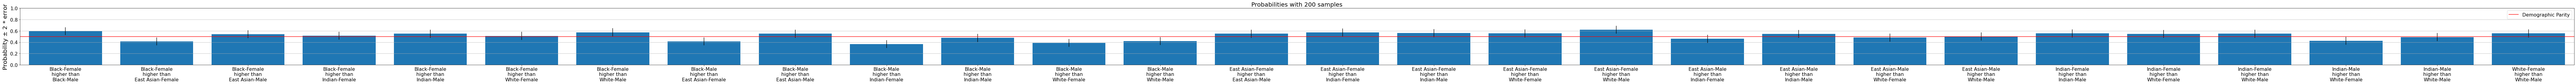

In [33]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(120, 4),
    x_label_angle=0,
)

## Pairing across all groups at once

In [141]:
# change the setting here
NUM_ITERATION = 10000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [142]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('East Asian', 'Female'), ('East Asian', 'Male'), ('Indian', 'Female'), ('Indian', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together1"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [143]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

In [144]:
def plot_dict_values(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    x_labels = ["{}-{}".format(*group_name) for group_name in stat_dict.keys()]
    print(x_labels)
    total = sum(stat_dict.values())
    print(type(total), type(list(stat_dict.values())))
    prob = list(stat_dict.values()) / total
    y_err = [confidence_interval_err * math.sqrt(p * (1 - p) / total) for p in prob]

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    ax.plot(
        [-0.5, len(x_labels) - 0.5],
        np.full(2, 1 / len(x_labels)),
        "r",
        label=f"average",
    )

    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    ax.yaxis.grid(True)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [145]:
max_salient_all_groups_stats

array([ 306., 1470., 1302., 1319., 1391., 1280., 1238., 1694.])

In [146]:
max_salient_all_groups_dict

{('Black', 'Female'): 306.0,
 ('Black', 'Male'): 1470.0,
 ('East Asian', 'Female'): 1302.0,
 ('East Asian', 'Male'): 1319.0,
 ('Indian', 'Female'): 1391.0,
 ('Indian', 'Male'): 1280.0,
 ('White', 'Female'): 1238.0,
 ('White', 'Male'): 1694.0}

['Black-Female', 'Black-Male', 'East Asian-Female', 'East Asian-Male', 'Indian-Female', 'Indian-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


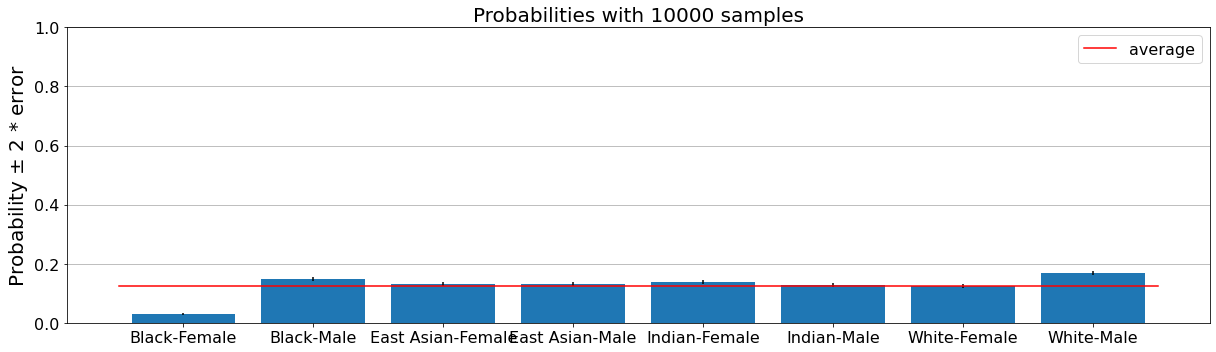

In [147]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [148]:
group_name_list = [('White', 'Male'), ('White', 'Female'), ('Indian', 'Male'), ('Indian', 'Female'), ('East Asian', 'Male'), ('East Asian', 'Female'), ('Black', 'Male'), ('Black', 'Female')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together2"

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [149]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['White-Male', 'White-Female', 'Indian-Male', 'Indian-Female', 'East Asian-Male', 'East Asian-Female', 'Black-Male', 'Black-Female']
<class 'numpy.float64'> <class 'list'>


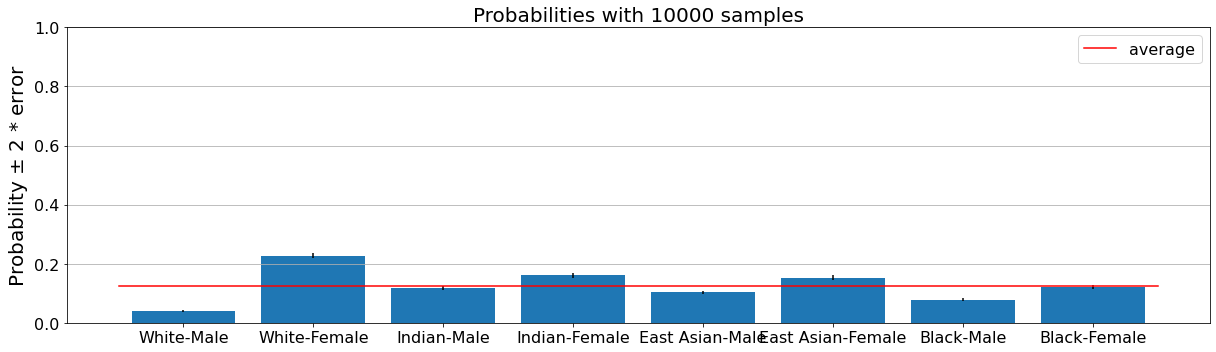

In [150]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [151]:
group_name_list = [('White', 'Male'), ('White', 'Female'), ('East Asian', 'Male'), ('East Asian', 'Female'), ('Indian', 'Male'), ('Indian', 'Female'), ('Black', 'Male'), ('Black', 'Female')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together3"

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [152]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['White-Male', 'White-Female', 'East Asian-Male', 'East Asian-Female', 'Indian-Male', 'Indian-Female', 'Black-Male', 'Black-Female']
<class 'numpy.float64'> <class 'list'>


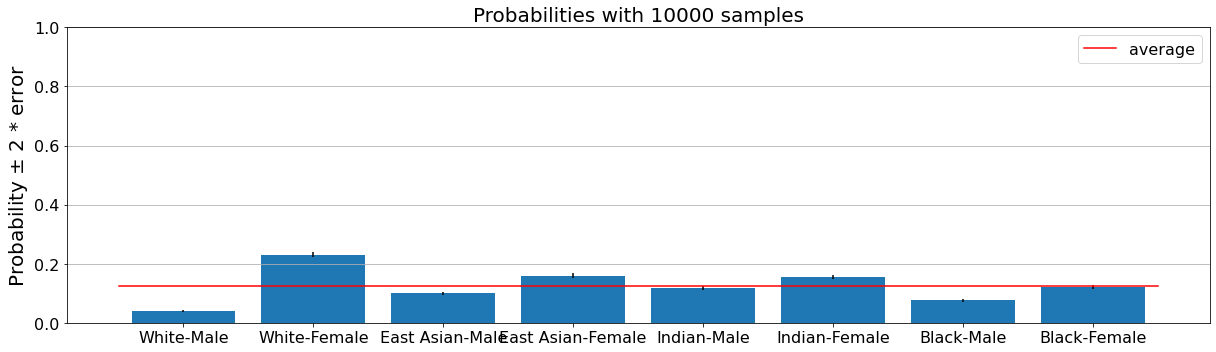

In [153]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [154]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('Indian', 'Female'), ('Indian', 'Male'), ('East Asian', 'Female'), ('East Asian', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together4"

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [155]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Black-Female', 'Black-Male', 'Indian-Female', 'Indian-Male', 'East Asian-Female', 'East Asian-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


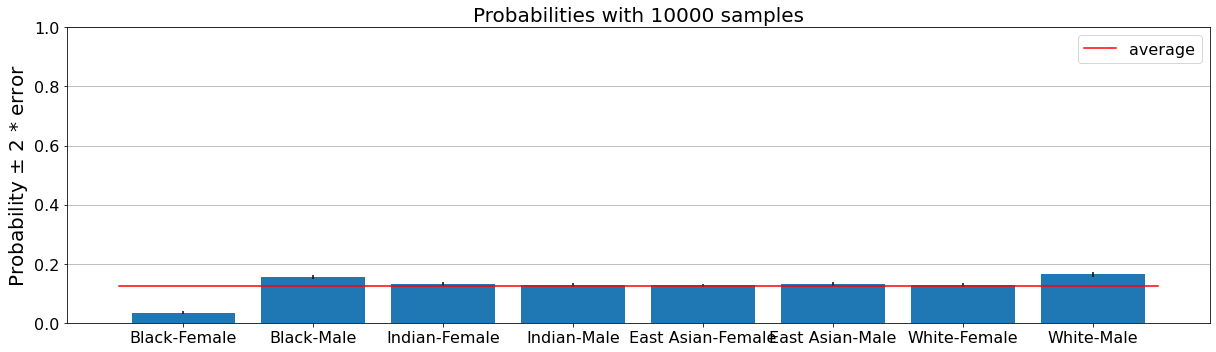

In [156]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [157]:
group_name_list = [('Indian', 'Female'), ('Indian', 'Male'), ('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male'), ('East Asian', 'Female'), ('East Asian', 'Male')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together5"

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [158]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Indian-Female', 'Indian-Male', 'Black-Female', 'Black-Male', 'White-Female', 'White-Male', 'East Asian-Female', 'East Asian-Male']
<class 'numpy.float64'> <class 'list'>


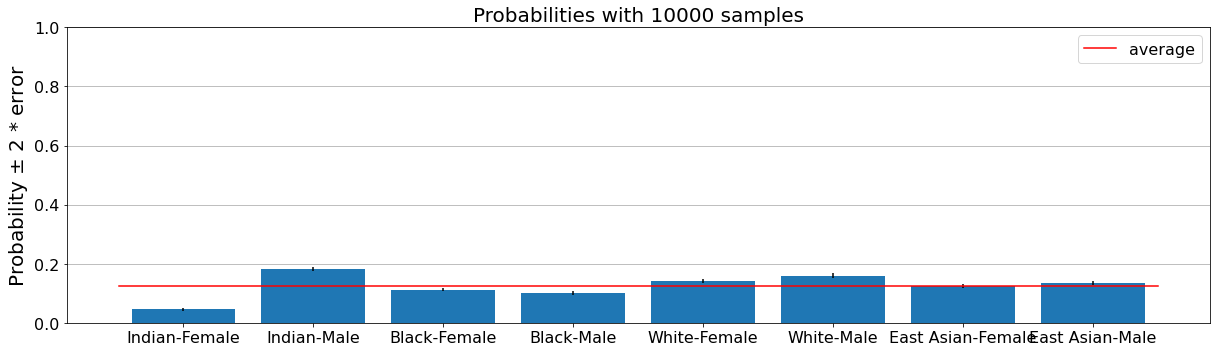

In [159]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [160]:
group_name_list = [('East Asian', 'Male'), ('East Asian', 'Female'), ('White', 'Male'), ('White', 'Female'), ('Black', 'Male'), ('Black', 'Female'), ('Indian', 'Male'), ('Indian', 'Female')]

SETTING_NAME = "fairface_4race_no_scaling_intersect_together6"

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 10000 iterations of sampling has been done.
200 / 10000 iterations of sampling has been done.
300 / 10000 iterations of sampling has been done.
400 / 10000 iterations of sampling has been done.
500 / 10000 iterations of sampling has been done.
600 / 10000 iterations of sampling has been done.
700 / 10000 iterations of sampling has been done.
800 / 10000 iterations of sampling has been done.
900 / 10000 iterations of sampling has been done.
1000 / 10000 iterations of sampling has been done.
1100 / 10000 iterations of sampling has been done.
1200 / 10000 iterations of sampling has been done.
1300 / 10000 iterations of sampling has been done.
1400 / 10000 iterations of sampling has been done.
1500 / 10000 iterations of sampling has been done.
1600 / 10000 iterations of sampling has been done.
1700 / 10000 iterations of sampling has been done.
1800 / 10000 iterations of sampling has been done.
1900 / 10000 iterations of sampling has been done.
2000 / 10000 iterations of sampling has 

In [161]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['East Asian-Male', 'East Asian-Female', 'White-Male', 'White-Female', 'Black-Male', 'Black-Female', 'Indian-Male', 'Indian-Female']
<class 'numpy.float64'> <class 'list'>


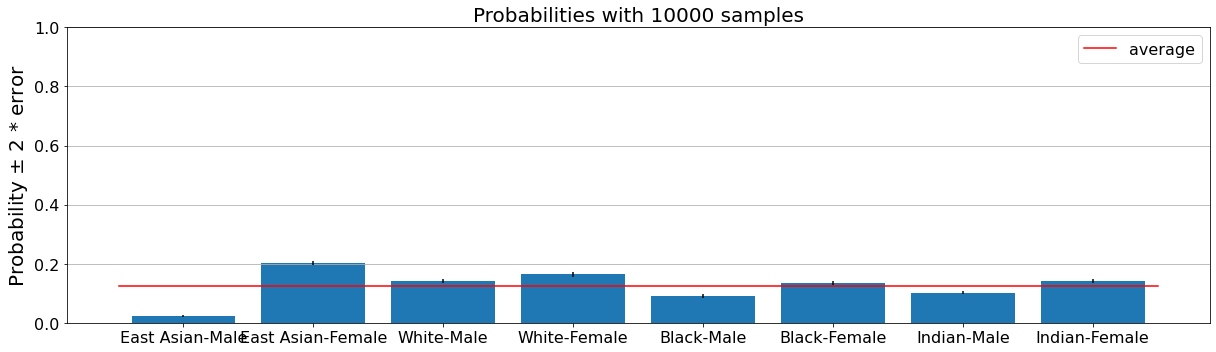

In [162]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

## Stats of saliency scores

In [163]:
# change the setting here
NUM_ITERATION = None  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_4race_no_scaling_intersect_stat"  # for saving results and plots

In [164]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
600 iterations of sampling has been done.
700 iterations of sampling has been done.
800 iterations of sampling has been done.
900 iterations of sampling has been done.
1000 iterations of sampling has been done.
1100 iterations of sampling has been done.
1200 iterations of sampling has been done.
1300 iterations of sampling has been done.
1400 iterations of sampling has been done.
1500 iterations of sampling has been done.
1600 iterations of sampling has been done.
1700 iterations of sampling has been done.
1800 iterations of sampling has been done.
1900 iterations of sampling has been done.
2000 iterations of sampling has been done.
2100 iterations of sampling has been done.
2200 iterations of sampling has been done.
2300 iterations of sam

2500 iterations of sampling has been done.
2600 iterations of sampling has been done.
2700 iterations of sampling has been done.
2800 iterations of sampling has been done.
2900 iterations of sampling has been done.
3000 iterations of sampling has been done.
3100 iterations of sampling has been done.
3200 iterations of sampling has been done.
total time used: 1351.1319842338562 seconds.
time used per comparison: 0.41895565402600193 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
600 iterations of sampling has been done.
700 iterations of sampling has been done.
800 iterations of sampling has been done.
900 iterations of sampling has been done.
1000 iterations of sampling has been done.
1100 iterations of sampling has been done.
1200 iterations of sampling has been done.
1300 ite

In [165]:
def prob_a_less_than_b(a, b):
    """
    Given two lists a,b, calculate the probability that
    random samples x,y from a,b will satisfies a < b
    
    Clculating this exactly for lists of length n, m takes runtime O(n log n + m log m) (for sorting),
    then O(n + m) in addition (without sorting)
    """
    a = sorted(a)
    b = sorted(b)

    prob = 0
    j = 0  # index of b that keeps moving till x > y
    for i, x in enumerate(a):
        while (j < len(b)) and (x >= b[j]):
            j += 1
        prob += (len(b) - j) / (len(a) * len(b))

    return prob

In [166]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5599443624857203
Probability that group ('Black', 'Female') >= ('East Asian', 'Female') is 0.4966078306992655
Probability that group ('Black', 'Female') >= ('East Asian', 'Male') is 0.5720697852262178
Probability that group ('Black', 'Female') >= ('Indian', 'Female') is 0.5193753600124054
Probability that group ('Black', 'Female') >= ('Indian', 'Male') is 0.5917331974746258
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5522039662084757
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.579033905074223
Probability that group ('Black', 'Male') >= ('East Asian', 'Female') is 0.4403276674719474
Probability that group ('Black', 'Male') >= ('East Asian', 'Male') is 0.5152089641916532
Probability that group ('Black', 'Male') >= ('Indian', 'Female') is 0.46395523580045384
Probability that group ('Black', 'Male') >= ('Indian', 'Male') is 0.5337982388187112
Probability that group ('Bla

In [167]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5701347179490787
Probability that group ('Black', 'Female') >= ('East Asian', 'Female') is 0.53989349496971
Probability that group ('Black', 'Female') >= ('East Asian', 'Male') is 0.6040930666424853
Probability that group ('Black', 'Female') >= ('Indian', 'Female') is 0.5460871266948292
Probability that group ('Black', 'Female') >= ('Indian', 'Male') is 0.6151453488372101
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5756559994272636
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.607249515232613
Probability that group ('Black', 'Male') >= ('East Asian', 'Female') is 0.4712894634189406
Probability that group ('Black', 'Male') >= ('East Asian', 'Male') is 0.535938646107069
Probability that group ('Black', 'Male') >= ('Indian', 'Female') is 0.47922964807676194
Probability that group ('Black', 'Male') >= ('Indian', 'Male') is 0.5464633561517491
Probability that group ('Black'

In [168]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_4race_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_4race_all_stats_dict_Black_Female.tsv
./fairface_4race_all_stats_dict_Black_Male.tsv
./fairface_4race_all_stats_dict_East Asian_Female.tsv
./fairface_4race_all_stats_dict_East Asian_Male.tsv
./fairface_4race_all_stats_dict_Indian_Female.tsv
./fairface_4race_all_stats_dict_Indian_Male.tsv
./fairface_4race_all_stats_dict_White_Female.tsv
./fairface_4race_all_stats_dict_White_Male.tsv


In [169]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_4race_no_scaling_intersect_stat
